# Knowledge Retrieval Method Tuning

The knowledge retrieval method would require tuning to the corpus in order to produce sensible results. One way to do it is to hand-label a corpus that contains an even distribution of scores and calibrate the threshold accordingly.

In [37]:
import pandas as pd
import sys
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import nltk

In [23]:
import numpy as np

In [3]:
sys.path.append("../src")

In [4]:
from data.topical_chat.annotators.knowledge.embedding import SentenceTransformerRetriever

In [9]:
train_retriever = SentenceTransformerRetriever("../data/intermediate/topical_chat/knowledge_embeddings/train_embeddings.pkl", torch.device("cuda"))

In [15]:
train_data = pd.read_parquet("../data/intermediate/topical_chat/parquet/conversations/train.parquet")

In [16]:
train_data.head()

,conversation_id,turn_index,message,agent,sentiment,knowledge_source,turn_rating
0,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,1,Are you a fan of Google or Microsoft?,agent_1,Curious to dive deeper,[FS1],Good
1,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,2,Both are excellent technology they are helpful...,agent_2,Curious to dive deeper,[FS1],Excellent
2,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,3,"I'm not a huge fan of Google, but I use it a ...",agent_1,Curious to dive deeper,[FS1],Good
3,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,4,Google provides online related services and pr...,agent_2,Curious to dive deeper,[FS1],Excellent
4,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,5,"Yeah, their services are good. I'm just not a ...",agent_1,Curious to dive deeper,[FS1],Good


In [18]:
tqdm.pandas()

In [21]:
document_score = train_data.progress_apply(lambda x: train_retriever.query(x['message'], x['conversation_id']), axis=1)

  0%|          | 0/188378 [00:00<?, ?it/s]

In [27]:
train_data['knowledge_sentence'] = document_score.apply(lambda x: x[0])
train_data['knowledge_similarity_score'] = document_score.apply(lambda x: float(x[1]))

Text(0, 0.5, 'Frequency')

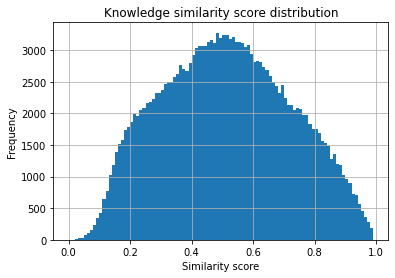

In [31]:
train_data['knowledge_similarity_score'].hist(bins=np.arange(0, 1, 0.01).tolist())
plt.title('Knowledge similarity score distribution')
plt.xlabel('Similarity score')
plt.ylabel('Frequency')

Interestingly the scores appear to be distributed centered around 0.5. Let's look at the 95% interval for the scores.

In [32]:
train_data['knowledge_similarity_score'].quantile([0.0275, 0.975])

0.0275    0.150909
0.9750    0.905992
Name: knowledge_similarity_score, dtype: float64

This shows that a vast majority of scores lie within \[0.15, 0.91\]

Let's look at the sentences that have the most similarity with the conversations.

In [34]:
mean_sentence_scores = train_data.groupby("knowledge_sentence").agg({"knowledge_similarity_score": "mean"})

In [35]:
mean_sentence_scores.sort_values("knowledge_similarity_score", ascending=False).head(10)

,knowledge_similarity_score
knowledge_sentence,
‘Hatred and evil’: How Trump follows a familiar script after national tragedies,0.970083
Kubrick wanted 90 tons of sand dyed gray for ‘2001’ — and that was just the start,0.968505
the Grammy awards were invented to counter the exploding popularity of Rock 'n Roll in the 1950's,0.954808
Uber agrees to settle data breach claims for record-setting $148 million,0.945378
Smallville was originally planned to be a show about Bruce Wayne becoming Batman,0.942855
"April the giraffe might be pregnant again, and it’s somehow news",0.926071
Ubisoft partnered with the British Museum to apply machine learning to speed the deciphering of ancient hieroglyphics,0.916152
Jaguars not alone in noticing the Patriots had just one penalty in AFC championship game,0.907659
"Target's sales growth is at a 13-year high, thanks to demand for toys and home goods",0.906155


In [36]:
mean_sentence_scores.sort_values("knowledge_similarity_score", ascending=False).tail(10)

,knowledge_similarity_score
knowledge_sentence,
"(NBC) Every so often, a sports broadcast gets fixated on a single character from the crowd and shows that person's reaction incessantly, after every moment good and bad, during every timeout, during every climactic moment. Maybe it's a coach's wife or husband. Maybe it's a player's parents or children. Maybe it's Bradley Beal, after he has fouled out during a playoff game. Maybe it's Bill Murray or Rudy Giuliani or Drake. Almost always, this is annoying. Almost always, viewers will say, ""Why won't they stop showing Mickie Krzyzewski, or Bill Murray or Drake?"" [2018 NHL Stanley Cup finals: Golden Knights-Capitals Game 4] Here is an exception: At some point during this playoff run, NBC's camera people decided they would start showing Alex Ovechkin's reaction incessantly, after every moment good and bad, during every timeout, during every climactic moment. And people can't get enough of these reactions. ""I love it,"" said longtime local hockey analyst Alan May, who like me, has been captivated by this development. ""It's childlike, and I'm saying that in a good way. That's just a guy that loves it all, that is living and dying in every moment here. For people who said this guy doesn't care, tell me that type of reaction is not caring. It's over the top, man.",0.077154
"For Navy QB with two career passes, spring is time to air things out (a little)",0.075925
"If being a jerk to a witness at a hearing were a crime, most of Congress would be locked up. However, an accounting of how the oversight process went badly awry and how to fix it will be needed. That perhaps can be undertaken in the context of an ethics proceeding, a subsequent Congress's intelligence committee or an independent commission. In short, we cannot have another House Intelligence Committee that behaves like this one; preventing that is the job of responsible lawmakers. Representatives who behaved dishonestly can be sanctioned by the House. There are, however, incidents that do smack of obstruction. Congressional votes and committee work, speeches on the floor and other action directly relating to the legislative process may be protected by the ""speech or debate"" clause. The constitutional provision protects members of Congress from being sued or prosecuted for carrying out their official duties. However, there is nothing official in sneaking over to the White House to review classified materials and then publicly misrepresenting them.",0.075491
I stepped down as U.S. ambassador to Estonia. Here’s why.,0.073480
"""We've just had some success in the postseason . . . I've had a lot of success in the postseason. ""Probably within the last five years, I bet [the Raptors have] improved in winning percentage every single year. But I guess their front office wants playoff success. That's what it boils down to, I guess."" As long as James is playing in the Eastern Conference, good luck to the Raptors - and everyone else - hoping to accomplish that. More NBA coverage: Pau Gasol: 'Becky Hammon can coach NBA basketball. Period.' Rockets are the toughest playoff opponent Steve Kerr's Warriors have ever faced The Philadelphia 76ers should go after Paul George, not LeBron James Will DeMarcus Cousins be back with the New Orleans Pelicans?",0.061608
"It represents what can happen to you when you have that call."" Well, that, and a refined three-point shot. Ingram shot 38.5 percent from three in college. His strength was attacking the rim and a solid midrange game, Jones said. He still averaged 15.2 points and 4.8 rebounds his senior season at AU. ""He was our best player through the course of his career,"" Jones said. Former American University star Andre Ingram, 32, finally got his NBA shot. (American University) But Ingram went undrafted by the NBA out of college and was selected in the seventh round of the G League draft, where he became one of the NBA's best prospects to never get called up. He played 384 games in that deve

There seems to be an obvious issue where the knowledge sentences that are too long tend to have low similarity. All of these come from the raw Washington Post articles. Let's verify if that pattern is discernible from a bivariate plot of number of tokens versus score.

In [39]:
train_data['knowledge_sentence_length'] = train_data['knowledge_sentence'].apply(lambda x: len(nltk.word_tokenize(x)))

Text(0.5, 1.0, 'Score vs. knowledge sentence length')

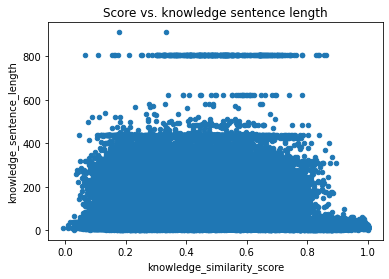

In [41]:
train_data.plot.scatter(x="knowledge_similarity_score", y="knowledge_sentence_length")
plt.title('Score vs. knowledge sentence length')

Interesting, there doesn't seem to be an obvious correlation between sentence length and similarity visually. Let's look at the cases with high score and long sentences.

**TODO:** Redo the above plot by plotting the frequency over a grid of (score, length) values.

### High similarity and high length cases

In [53]:
high_similarity_length_cases = train_data[(train_data['knowledge_sentence_length'] > 400) & (train_data['knowledge_sentence_length'] < 600) & (train_data['knowledge_similarity_score'] > 0.7)][['message', 'knowledge_sentence', 'knowledge_similarity_score']]

In [54]:
for entry in high_similarity_length_cases.iloc[:50].itertuples():
    
    print(entry.message)
    print()
    print(entry.knowledge_sentence)
    print(f"Similarity score: {entry.knowledge_similarity_score}")
    print()

I didn't know the rapper Drake, was Canadian, did you?

Aubrey Drake Graham (born October 24, 1986), known mononymously as Drake, is a Canadian rapper, singer, songwriter, record producer, actor, and entrepreneur. Drake initially gained recognition as an actor on the teen drama television series Degrassi: The Next Generation in the early 2000s. Intent on pursuing a career as a rapper, he departed the series in 2007 following the release of his debut mixtape, Room for Improvement. He released two further independent projects, Comeback Season and So Far Gone, before signing to Lil Wayne's Young Money Entertainment in June 2009.Drake released his debut studio album Thank Me Later in 2010, which debuted at number one on the US Billboard 200 and was soon certified platinum. His next two releases, 2011's Take Care and 2013's Nothing Was the Same, were critically and commercially successful; the former earned him his first Grammy Award for Best Rap Album. In 2015, he released two mixtapes—the

This is actually quite fascinating, the model appears to capture semantic information involving nouns and named entities. It's even able to match long descriptions with short utterances. However, it could also indicate that the model pays heavy attention to the initial parts of the input rather than the latter parts of the input. Additionally, it is consistent with user behavior where most of the attention is paid to the head of the input rather than the tail.

### Low similarity and low length cases

In [57]:
low_similarity_length_cases = train_data[(train_data['knowledge_sentence_length'] < 100) & (train_data['knowledge_similarity_score'] < 0.2)][['message', 'knowledge_sentence', 'knowledge_similarity_score']]

In [58]:
for entry in low_similarity_length_cases.iloc[:50].itertuples():
    
    print(entry.message)
    print()
    print(entry.knowledge_sentence)
    print(f"Similarity score: {entry.knowledge_similarity_score}")
    print()

Both are excellent technology they are helpful in many ways. For the security purpose both are super.

A single Google search requires more computing power than it took to send Neil Armstrong and eleven other astronauts to the moon
Similarity score: 0.17566724121570587

Yeah they are much smarter than we give them credit for

Shakespeare invented the names Miranda, Jessica, and Olivia.
Similarity score: 0.16289439797401428

I wonder if they met how that would go from there

Levi made Bing Crosby a denim tuxedo after he was turned away from a hotel for wearing jeans
Similarity score: 0.19493067264556885

I am really bad, but it is a good time.

professional ballet dancers can go through 4 pairs of pointe shoes in a week.
Similarity score: 0.07595402002334595

I didn't know this thanks for sharing.

Vans, North Face, Nautica, Jansport, Timberland, Lee Jeans, Wrangler... are all owned by the same company
Similarity score: 0.16877271234989166

Ha Ha!!! It was so nice chatting with you as w

One thing to note is that a lot of the low similarity cases involve function sentences or low information sentences. Could we identify those cases accurately whenever possible?